In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow import keras
import numpy as np
import tensorflow as tf
from scipy.stats import norm
from keras.models import Model
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from tensorflow.keras import layers
import operator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter
from imblearn.over_sampling import SMOTE

#Creazione Modello VAE

In [ ]:
from keras import backend as K
from tensorflow.keras.metrics import Accuracy as accuracy
from tensorflow.keras.metrics import Precision as precision


#https://blog.keras.io/building-autoencoders-in-keras.html

original_dim = 108 #feature 108
intermediate_dim = 500
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])
#print(z)
# Create encoder: un codificatore che mappa gli input allo spazio latente
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')
encoder.summary()
# Create decoder: un generatore che può prendere punti sullo spazio latente e e restituisce i campioni ricostruiti corrispondenti.
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')
decoder.summary()
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim

kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam') 
vae.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 108)]        0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 500)          54500       input_2[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 2)            1002        dense_7[0][0]                    
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 2)            1002        dense_7[0][0]                    
____________________________________________________________________________________________

In [ ]:
#https://www.datacamp.com/community/tutorials/autoencoder-classifier-python
num_classes = 2
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(200, activation='relu')(flat)
    out = Dense(num_classes, activation='softmax')(den)
    return out

encode = encoder(inputs)[2]
print(encode)
full_model = Model(inputs,fc(encode))

Tensor("encoder/lambda_1/add_1:0", shape=(None, 2), dtype=float32)


In [ ]:
'''
Funzione per fare oversampling solo sul training (nella fase di K-fold split)
@return oversampling sui campioni, oversampling sulle etichette (status)
'''
def oversampling_training(dataset_training, y_status, y_tipology):
  y_status = pd.Series(y_status)
  y_tipology = pd.Series(y_tipology)   
  data = {"STATUS": y_status, "Tipologia": y_tipology} 
  data_class = pd.concat(data, axis = 1) 
  print("Numero di Sample per Status:")
  print(y_status.value_counts())

  tuple_class = list(map(tuple, data_class.to_numpy()))
  #print(len(tuple_class))  #45 sample
  encode_tuple = { (0,0) : 1, (0,1) : 2, (0,2) : 3, (1,0) : 4, (1,1) : 5, (1,2) : 6}
  macro_class = []
  for couple in tuple_class: 
    macro_class.append(encode_tuple[couple])

  series_macro_class = pd.Series((v for v in macro_class) )

  #print("NUMERO DI TUPLE PER CLASSE MACRO:")
  print(series_macro_class.value_counts())

   # Oversampling "NORMALE" sullo STATUS
  oversample = SMOTE(k_neighbors=1)    
  data_objs_oversampling, macro_class_oversampling = oversample.fit_resample(dataset_training, y_status)
  
 
  # Oversampling NORMALE sulle Tipologie   ( problema: troppo pochi esempi per la classe '3')
  '''
  oversample = SMOTE(k_neighbors=1)     #Expected n_neighbors <= n_samples,  but n_samples = 2, n_neighbors = 3
  data_objs_oversampling, macro_class_oversampling = oversample.fit_resample(dataset_training, series_macro_class)
  '''

 
  # Oversampling ALTERNATIVO sulle Tipologie   :FACCIO OVERSAMPLING SOLO DELLE SOTTOCLASSI DEBOLI  ( problema: troppo pochi esempi per la classe '3')
                                                                   #Expected n_neighbors <= n_samples,  but n_samples = 1, n_neighbors = 2
  '''
  table_count = series_macro_class.value_counts()
  table_count = table_count.to_dict()
  #print(table_count) 
  #print(table_count[1])   
  #print(type(table_count[1]))  
  n_sintetic = 0                                            
  oversample = SMOTE({1: table_count[1]+ n_sintetic ,2: table_count[2]+ n_sintetic , 6: table_count[6]+ n_sintetic,
                      3: table_count[6]+n_sintetic , 4: table_count[1] +n_sintetic, 5: table_count[2]+n_sintetic}, k_neighbors=1) 
  data_objs_oversampling, macro_class_oversampling = oversample.fit_resample(dataset_training, series_macro_class)
  '''
  '''
  #PRIMA DELLA FASE DI APPRENDIMENTO DEVO DECODIFICARE LE NUOVE ETICHETTE Y (STATUS:0,1)
  #DALL'OVERSAMPLING DELLA MACRO_CLASS DEVO CODIFICARE LE NUOVE ETICHETTE
  micro_class = list()
  for encoded in macro_class_oversampling: 
    #print(encoded)
    for key, value in encode_tuple.items():  #  in dictionary.iteritems():  (for Python 2.x)
      if encoded == value:
          #print(key)
          micro_class.append(key)
  #print(micro_class)
  new_df = pd.DataFrame(micro_class, columns=['STATUS', 'Tipologia'])
  #print(new_df)
  y=new_df['STATUS']
  #print(y)
  #print("Nuova lunghezza del vettore target y (dopo l'oversampling): ", len(y))
  return data_objs_oversampling, y
  '''
  return data_objs_oversampling, macro_class_oversampling

In [ ]:
input = pd.read_csv("/content/drive/My Drive/dati/dati_experiment/file2.csv") #Carico il dataset
data_obj = pd.DataFrame(input) #.sample(frac=1)
data_obj_droped = data_obj.drop(columns=['PSA', 'ETA','STATUS','Tipologia']) 
y = data_obj['STATUS']

#Standardizzazione dei valori del dataset
scaler = StandardScaler(with_std=True)
scaler.fit(data_obj_droped) 
data_objs = scaler.transform(data_obj_droped) 
data_objs

array([[-0.31, -0.15,  0.65, ..., -0.92, -0.23,  0.15],
       [-0.31, -0.15,  0.65, ..., -0.92, -0.23,  0.15],
       [-0.31, -0.15,  0.65, ..., -0.5 , -0.23,  0.15],
       ...,
       [ 0.54, -0.15,  0.54, ...,  2.27, -0.22, -6.63],
       [ 3.05, -0.14,  0.18, ..., -0.91,  3.69,  0.14],
       [ 5.69, -0.14, -0.12, ..., -0.9 ,  5.39,  0.14]])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
batch_size = 32
n = data_obj_droped
test_predicted_vae = np.zeros((np.array(n).shape[0],)) 

#Uso Vae per la classificazione senza fare Oversampling (con Smote)

In [ ]:
#Uso Vae per la classificazione senza Oversampling 
dict_model = { "vae": {"accuracy": [], "precision": [], "recall": []}, }
i = 0

ext_fold = 9
fold_obj_ext = StratifiedKFold(ext_fold,  True, random_state = 4)  #Stratified 9-fold esterno

n_fold = 5
fold_obj = StratifiedKFold(n_fold ,  True, random_state = 4)       #Stratified 5-fold interno


for train_idx_ext, test_idx_ext in fold_obj_ext.split(data_objs, y): 

  X_train_ext, X_test = data_objs[train_idx_ext, :], data_objs[test_idx_ext, :]
  y_train_ext, y_test = y[train_idx_ext], y[test_idx_ext]
  test_Y_one_hot = to_categorical(y_test) #test_labels
  indices = np.array(range(len(X_train_ext)))
  y_train_ext = np.array(y_train_ext)[indices.astype(int)]

  for train_idx, val_idx in fold_obj.split(X_train_ext, y_train_ext): 
       
        i += 1
        print("Fold: " + str(i))
              
        X_train, X_valid = X_train_ext[train_idx, :], X_train_ext[val_idx, :]                  
        y_train, y_valid = y_train_ext[train_idx], y_train_ext[val_idx]
                                                                                                                                                                                                                                                                #y_valid 
        vae.fit(X_train, y_train, epochs=200, batch_size=batch_size, shuffle=True, verbose=0, callbacks=[callback], validation_data=(X_valid, y_valid))
       
        #valid_Y_one_hot = to_categorical(y_valid) #training labels
                                        
  train_Y_one_hot = to_categorical(y_train) #training labels
  
    
  #In questa fase i layers utilizzati dall’encoder devono essere prima “spenti” (settati a False). Poi in
  #un secondo momento, devono essere “riaccesi” (settati a True), per effettuare l’apprendimento sulla rete
  #Encoder + MPL.
            
  for layer in full_model.layers[0:2]:

    layer.trainable = False  
        
  full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
  #full_model.summary()
        
  train_label = train_Y_one_hot
  train_X = X_train


                        #MLP                                                                            
  classify_train = full_model.fit(train_X, train_label, batch_size=32,epochs=200,verbose=0,validation_data=(train_X, train_label))
        
  for layer in full_model.layers[0:2]:

     layer.trainable = True

  full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
        
  #Ultimo step Train
  classify_train = full_model.fit(train_X, train_label, batch_size=batch_size,epochs=200,verbose=0,validation_data=(train_X, train_label))

        
  test_data = X_test
  test_labels = y_test 

  scores = full_model.evaluate(test_data, test_Y_one_hot, verbose=1)
  print('Test loss:', scores[0])
  print('Test accuracy:', scores[1])
  predicted_classes = full_model.predict(test_data)
  predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

  test_predicted_vae[test_idx_ext] = predicted_classes

  correct = np.where(predicted_classes==test_labels)[0]
  print ("Found %d correct labels" % len(correct))

  incorrect = np.where(predicted_classes!=test_labels)[0]
  print ("Found %d incorrect labels" % len(incorrect)) 

        #classification report
  target_names = ["Class {}".format(i) for i in range(num_classes)]
  print(classification_report(test_labels, predicted_classes, target_names=target_names))
    
  print("End of kfold")


Fold: 1
Fold: 2
Fold: 3
Fold: 4
Fold: 5
1/1 [==============================] - 0s 1ms/step - loss: 0.2874 - accuracy: 0.8000
Test loss: 0.2873508632183075
Test accuracy: 0.800000011920929
Found 4 correct labels
Found 1 incorrect labels
              precision    recall  f1-score   support

     Class 0       1.00      0.67      0.80         3
     Class 1       0.67      1.00      0.80         2

    accuracy                           0.80         5
   macro avg       0.83      0.83      0.80         5
weighted avg       0.87      0.80      0.80         5

End of kfold
Fold: 6
Fold: 7
Fold: 8
Fold: 9
Fold: 10
1/1 [==============================] - 0s 1ms/step - loss: 0.7121 - accuracy: 0.8000
Test loss: 0.7121333479881287
Test accuracy: 0.800000011920929
Found 4 correct labels
Found 1 incorrect labels
              precision    recall  f1-score   support

     Class 0       1.00      0.67      0.80         3
     Class 1       0.67      1.00      0.80         2

    accuracy           

##Uso Vae per la classificazione CON Oversampling (Smote)

In [ ]:
#Uso Vae per la classificazione CON Oversampling 
dict_model = { "vae": {"accuracy": [], "precision": [], "recall": []}, }
i = 0

ext_fold = 9
fold_obj_ext = StratifiedKFold(ext_fold,  True, random_state = 4) 

col_typology = data_obj['Tipologia']   #ci serve per fare l'oversampling sulle tipologie

for train_idx_ext, test_idx_ext in fold_obj_ext.split(data_objs, y): 

  X_train_ext, X_test = data_objs[train_idx_ext, :], data_objs[test_idx_ext, :]
  y_train_ext, y_test = y[train_idx_ext], y[test_idx_ext]
  test_Y_one_hot = to_categorical(y_test) #test_labels
 
  indices = np.array(range(len(X_train_ext)))
  y_train_ext = np.array(y_train_ext)[indices.astype(int)]

  
  y_tipology = col_typology[train_idx_ext]
  y_tipology_ext = np.array(y_tipology)[indices.astype(int)]

                                     
  for train_idx, val_idx in fold_obj.split(X_train_ext, y_train_ext): 
        i += 1
        print("Fold: " + str(i))
        
        X_train, X_valid = X_train_ext[train_idx, :], X_train_ext[val_idx, :]
                       
        y_train, y_valid = y_train_ext[train_idx], y_train_ext[val_idx]

        y_tipology_int = y_tipology_ext[train_idx]

        X_oversampled, y_oversampled = oversampling_training(X_train, y_train, y_tipology_int) #richiamo la funzione che fa oversampling sul dataset e su y

        #print("X_train oversampled", len(X_oversampled))
        #print("y_train oversampled", len(y_oversampled))

        X_train = X_oversampled
        y_train = y_oversampled

        print("TRAINING oversampled: ", len(X_train))
        print("Validation sample: ", len(X_valid))
                                                                                                                                     
        vae.fit(X_train, y_train, epochs=200, batch_size=batch_size, shuffle=True, verbose=0, callbacks=[callback], validation_data=(X_valid, y_valid))
         
        #valid_Y_one_hot = to_categorical(y_valid) #training labels
                                        
  train_Y_one_hot = to_categorical(y_train) #training labels

  #In questa fase i layers utilizzati dall’encoder devono essere prima “spenti” (settati a False). Poi in
  #un secondo momento, devono essere “riaccesi” (settati a True), per effettuare l’apprendimento sulla rete
  #Encoder + MPL.
  for layer in full_model.layers[0:2]:

    layer.trainable = False  
        
  full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
  #full_model.summary()
        
  train_label = train_Y_one_hot
  train_X = X_train

                        #MLP                                                                        
  classify_train = full_model.fit(train_X, train_label, batch_size=32,epochs=200,verbose=0,validation_data=(train_X, train_label))
        
  for layer in full_model.layers[0:2]:

     layer.trainable = True

  full_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
        
  #Ultimo step Train
  classify_train = full_model.fit(train_X, train_label, batch_size=batch_size,epochs=200,verbose=0,validation_data=(train_X, train_label))

        
  test_data = X_test
  test_labels = y_test 

  scores = full_model.evaluate(test_data, test_Y_one_hot, verbose=1)
  print('Test loss:', scores[0])
  print('Test accuracy:', scores[1])
  predicted_classes = full_model.predict(test_data)
  predicted_classes = np.argmax(np.round(predicted_classes),axis=1)

  test_predicted_vae[test_idx_ext] = predicted_classes

  correct = np.where(predicted_classes==test_labels)[0]
  print ("Found %d correct labels" % len(correct))

  incorrect = np.where(predicted_classes!=test_labels)[0]
  print ("Found %d incorrect labels" % len(incorrect)) 

        #classification report
  target_names = ["Class {}".format(i) for i in range(num_classes)]
  print(classification_report(test_labels, predicted_classes, target_names=target_names))
    
  print("End of kfold")

Fold: 1
Numero di Sample per Status:
1    16
0    16
dtype: int64
2    9
6    7
1    6
5    5
4    4
3    1
dtype: int64
TRAINING oversampled:  32
Validation sample:  8
Fold: 2
Numero di Sample per Status:
1    16
0    16
dtype: int64
2    10
6     7
5     5
4     4
1     4
3     2
dtype: int64
TRAINING oversampled:  32
Validation sample:  8
Fold: 3
Numero di Sample per Status:
1    16
0    16
dtype: int64
2    9
6    7
4    5
1    5
5    4
3    2
dtype: int64
TRAINING oversampled:  32
Validation sample:  8
Fold: 4
Numero di Sample per Status:
1    16
0    16
dtype: int64
2    9
6    7
1    6
5    5
4    4
3    1
dtype: int64
TRAINING oversampled:  32
Validation sample:  8
Fold: 5
Numero di Sample per Status:
1    16
0    16
dtype: int64
6    8
2    7
1    7
5    5
4    3
3    2
dtype: int64
TRAINING oversampled:  32
Validation sample:  8
1/1 [==============================] - 0s 2ms/step - loss: 0.1027 - accuracy: 1.0000
Test loss: 0.10273033380508423
Test accuracy: 1.0
Found 5 correc

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Fold: 28
Numero di Sample per Status:
0    17
1    15
dtype: int64
2    8
6    6
1    6
5    5
4    4
3    3
dtype: int64
TRAINING oversampled:  34
Validation sample:  8


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Fold: 29
Numero di Sample per Status:
0    17
1    15
dtype: int64
2    8
1    7
6    6
4    5
5    4
3    2
dtype: int64
TRAINING oversampled:  34
Validation sample:  8


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Fold: 30
Numero di Sample per Status:
0    17
1    15
dtype: int64
2    8
6    6
1    6
5    5
4    4
3    3
dtype: int64
TRAINING oversampled:  34
Validation sample:  8


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


1/1 [==============================] - 0s 1ms/step - loss: 0.2200 - accuracy: 1.0000
Test loss: 0.2199706733226776
Test accuracy: 1.0
Found 5 correct labels
Found 0 incorrect labels
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00         2
     Class 1       1.00      1.00      1.00         3

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5

End of kfold
Fold: 31
Numero di Sample per Status:
1    16
0    16
dtype: int64
2    9
6    6
5    5
4    5
1    5
3    2
dtype: int64
TRAINING oversampled:  32
Validation sample:  8
Fold: 32
Numero di Sample per Status:
0    17
1    15
dtype: int64
2    11
6     7
5     4
4     4
1     4
3     2
dtype: int64
TRAINING oversampled:  34
Validation sample:  8


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Fold: 33
Numero di Sample per Status:
0    17
1    15
dtype: int64
2    8
6    6
1    6
5    5
4    4
3    3
dtype: int64
TRAINING oversampled:  34
Validation sample:  8


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Fold: 34
Numero di Sample per Status:
0    17
1    15
dtype: int64
6    9
2    8
1    7
5    3
4    3
3    2
dtype: int64
TRAINING oversampled:  34
Validation sample:  8


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Fold: 35
Numero di Sample per Status:
0    17
1    15
dtype: int64
6    8
2    8
1    6
4    4
5    3
3    3
dtype: int64
TRAINING oversampled:  34
Validation sample:  8


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


1/1 [==============================] - 0s 1ms/step - loss: 3.7489e-04 - accuracy: 1.0000
Test loss: 0.000374891038518399
Test accuracy: 1.0
Found 5 correct labels
Found 0 incorrect labels
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00         2
     Class 1       1.00      1.00      1.00         3

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5

End of kfold
Fold: 36
Numero di Sample per Status:
1    16
0    16
dtype: int64
6    7
2    7
1    7
4    5
5    4
3    2
dtype: int64
TRAINING oversampled:  32
Validation sample:  8
Fold: 37
Numero di Sample per Status:
0    17
1    15
dtype: int64
6    9
2    9
1    6
5    3
4    3
3    2
dtype: int64
TRAINING oversampled:  34
Validation sample:  8


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Fold: 38
Numero di Sample per Status:
0    17
1    15
dtype: int64
2    9
6    5
5    5
4    5
1    5
3    3
dtype: int64
TRAINING oversampled:  34
Validation sample:  8


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Fold: 39
Numero di Sample per Status:
0    17
1    15
dtype: int64
6    9
1    8
2    7
5    3
4    3
3    2
dtype: int64
TRAINING oversampled:  34
Validation sample:  8


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Fold: 40
Numero di Sample per Status:
0    17
1    15
dtype: int64
2    8
6    6
1    6
5    5
4    4
3    3
dtype: int64
TRAINING oversampled:  34
Validation sample:  8


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


1/1 [==============================] - 0s 1ms/step - loss: 0.0284 - accuracy: 1.0000
Test loss: 0.028372738510370255
Test accuracy: 1.0
Found 5 correct labels
Found 0 incorrect labels
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00         2
     Class 1       1.00      1.00      1.00         3

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5

End of kfold
Fold: 41
Numero di Sample per Status:
1    16
0    16
dtype: int64
2    8
6    6
5    6
1    6
4    4
3    2
dtype: int64
TRAINING oversampled:  32
Validation sample:  8
Fold: 42
Numero di Sample per Status:
0    17
1    15
dtype: int64
2    9
1    6
6    5
5    5
4    5
3    2
dtype: int64
TRAINING oversampled:  34
Validation sample:  8


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Fold: 43
Numero di Sample per Status:
0    17
1    15
dtype: int64
2    9
5    7
6    5
1    5
4    3
3    3
dtype: int64
TRAINING oversampled:  34
Validation sample:  8


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Fold: 44
Numero di Sample per Status:
0    17
1    15
dtype: int64
1    8
6    7
2    7
5    4
4    4
3    2
dtype: int64
TRAINING oversampled:  34
Validation sample:  8


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Fold: 45
Numero di Sample per Status:
0    17
1    15
dtype: int64
2    7
1    7
5    6
6    5
4    4
3    3
dtype: int64
TRAINING oversampled:  34
Validation sample:  8


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


1/1 [==============================] - 0s 1ms/step - loss: 0.0021 - accuracy: 1.0000
Test loss: 0.0021291181910783052
Test accuracy: 1.0
Found 5 correct labels
Found 0 incorrect labels
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00         2
     Class 1       1.00      1.00      1.00         3

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5

End of kfold


In [ ]:
'''
Funzione per plottare le matrici di confusione
'''
import itertools
#Evaluation of Model - Confusion Matrix Plot
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center")
                # color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print("\n\nRisultati metriche VAE: \n")

print("Accuracy VAE: ", accuracy_score(y,test_predicted_vae))
print("\nPrecision VAE: ", precision_score(y,test_predicted_vae))
print("\nRecall VAE: ", recall_score(y,test_predicted_vae))

#VAE
dict_model['vae']['accuracy'].append(accuracy_score(y,test_predicted_vae))
dict_model['vae']['precision'].append(precision_score(y,test_predicted_vae))
dict_model['vae']['recall'].append(recall_score(y,test_predicted_vae))





Risultati metriche VAE: 

Accuracy VAE:  0.9555555555555556

Precision VAE:  0.9545454545454546

Recall VAE:  0.9545454545454546


#Salvataggio dati (no oversampling)

[0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.]
[[19  4]
 [ 4 18]]
Confusion matrix, without normalization
[[19  4]
 [ 4 18]]


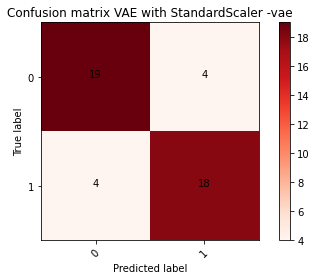

In [ ]:
#SENZA OVERSAMPLING
label = ["vae"]  
dict_pred = {  "vae": {"y_pred": []},}
#Vae
dict_pred['vae']['y_pred'].append(test_predicted_vae)

for name in label: 
  y_pred = dict_pred[name]['y_pred']
  print(y_pred[0])
  cnf_matrix = confusion_matrix(y, y_pred[0])
  np.set_printoptions(precision=2)
  print(cnf_matrix)
  plt.figure()
  tit = 'Confusion matrix VAE with StandardScaler -' + name 
  plot_confusion_matrix(cnf_matrix, classes=['0','1'], title= tit)
  plt.savefig('/content/drive/My Drive/dati/test_vae/Plot/mat_conf/' + tit +'.png')

In [ ]:
#SALVO I DATI DELLE METRICHE (senza oversampling)
for key in dict_model.keys():   
    np.save('/content/drive/My Drive/dati/test_vae/StandardScaler/accuracy_'+ str(key) , list(dict_model[key]['accuracy']))
    np.save('/content/drive/My Drive/dati/test_vae/StandardScaler/precision_'+ str(key) , list(dict_model[key]['precision']))
    np.save('/content/drive/My Drive/dati/test_vae/StandardScaler/recall_'+ str(key) , list(dict_model[key]['recall']))
 

#Salvataggio dati (si oversampling)

[0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0.
 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1.]
[[22  1]
 [ 1 21]]
Confusion matrix, without normalization
[[22  1]
 [ 1 21]]


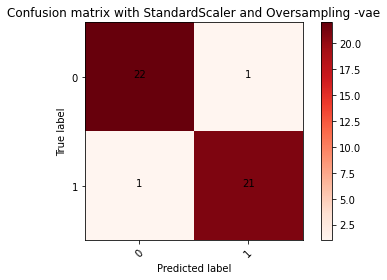

In [ ]:
#CON OVERSAMPLING
label = ["vae"]  
dict_pred = {  "vae": {"y_pred": []},}
#Vae
dict_pred['vae']['y_pred'].append(test_predicted_vae)

for name in label: 
  y_pred = dict_pred[name]['y_pred']
  print(y_pred[0])
  cnf_matrix = confusion_matrix(y, y_pred[0])
  np.set_printoptions(precision=2)
  print(cnf_matrix)
  plt.figure()
  tit = 'Confusion matrix with StandardScaler and Oversampling -' + name 
  plot_confusion_matrix(cnf_matrix, classes=['0','1'], title= tit)
  #plt.savefig('/content/drive/My Drive/dati/test_vae/Plot/mat_conf/' + tit +'.png')

In [ ]:
#SALVO I DATI DELLE METRICHE (CON oversampling)
for key in dict_model.keys():   
    np.save('/content/drive/My Drive/dati/test_vae/StandardScaler/accuracy_'+ str(key) + '_oversampling', list(dict_model[key]['accuracy']))
    np.save('/content/drive/My Drive/dati/test_vae/StandardScaler/precision_'+ str(key) + '_oversampling', list(dict_model[key]['precision']))
    np.save('/content/drive/My Drive/dati/test_vae/StandardScaler/recall_'+ str(key) + '_oversampling', list(dict_model[key]['recall']))
 


#PLOT di comparazione tra metriche (con e senza uso di oversampling nella classificazione con VAE)

0    0.818182
1    0.954545
dtype: float64
[0.8181818181818182, 0.9545454545454546]
0    0.818182
1    0.954545
dtype: float64
0    0.822222
1    0.955556
dtype: float64


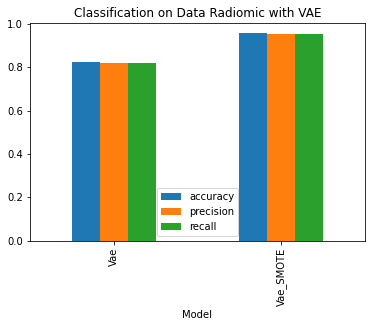

In [ ]:
item_accuracy, item_precision, item_recall = [] , [] , []
labels = ['Vae', 'Vae_SMOTE']
temp = []

value_acc = np.load('/content/drive/My Drive/dati/test_vae/StandardScaler/accuracy_'+ str(label[0]) + '.npy', allow_pickle=True)
for v in value_acc: 
  temp.append(v)
item_accuracy.append(tuple(temp)[0])
temp.clear()
del value_acc
value_acc = np.load('/content/drive/My Drive/dati/test_vae/StandardScaler/accuracy_'+ str(label[0]) + '_oversampling.npy', allow_pickle=True)
for v in value_acc: 
  temp.append(v)
item_accuracy.append(tuple(temp)[0])
temp.clear()

value_pre = np.load('/content/drive/My Drive/dati/test_vae/StandardScaler/precision_'+ str(label[0]) + '.npy', allow_pickle=True)
for v in value_pre: 
   temp.append(v)
item_precision.append(tuple(temp)[0])
temp.clear()
del value_pre
value_pre = np.load('/content/drive/My Drive/dati/test_vae/StandardScaler/precision_'+ str(label[0]) + '_oversampling.npy', allow_pickle=True)
for v in value_pre: 
   temp.append(v)
item_precision.append(tuple(temp)[0])
temp.clear()

value_rec = np.load('/content/drive/My Drive/dati/test_vae/StandardScaler/recall_'+ str(label[0]) + '.npy', allow_pickle=True)
for v in value_rec: 
  temp.append(v)
item_recall.append(tuple(temp)[0])
temp.clear()
del value_rec
value_rec = np.load('/content/drive/My Drive/dati/test_vae/StandardScaler/recall_'+ str(label[0]) + '_oversampling.npy', allow_pickle=True)
for v in value_rec: 
  temp.append(v)
item_recall.append(tuple(temp)[0])
temp.clear()

item_recall = pd.Series(item_recall)
print(item_recall)


print(item_precision)
item_precision = pd.Series(item_precision)
print(item_precision)

item_accuracy = pd.Series(item_accuracy)
print(item_accuracy)

df = pd.DataFrame({'accuracy':item_accuracy,'precision': item_precision, 'recall': item_recall, 'Model': labels})
title = "Classification on Data Radiomic with VAE"
plot = df.plot(x= 'Model', kind='bar', legend=True, title = title)
fig = plot.get_figure()

fig.savefig('/content/drive/My Drive/dati/test_vae/Plot/' + title + '.png')